# Welcome to the Optimal Portfolio Allocation Engine, Hamilton–Jacobi–Bellman (PDE-based) Decision Interactive Dashboard ! 

This research-oriented dashboard provides a structured framework to study dynamic portfolio allocation under uncertainty using stochastic control techniques. It implements a complete buy-side decision pipeline, from market assumptions and investor risk preferences to optimal allocation policies, realistic implementation, and final strategy comparison.

The objective is not return forecasting, but allocation interpretation: understanding how different portfolio rules perform net of transaction costs when evaluated through an investor’s expected utility. The framework models a continuous-time market with a risky asset and cash, defines an investor with CRRA preferences, computes the theoretically optimal allocation via the HJB equation, and benchmarks this solution against standard buy-side strategies under identical market scenarios.

At its core, the dashboard addresses the central buy-side question: how should a portfolio be dynamically allocated to maximize expected utility under uncertainty and implementation constraints?

## How to Use the Dashboard

**Step 1 — Configure the Scenario**

In the Input Parameters section, specify:
- market assumptions (expected return, volatility, interest rate, horizon),
- investor risk aversion,
- implementation realism (transaction costs, leverage or short-selling constraints),
- numerical resolution and simulation settings.

The market model assumes constant drift and volatility, and transaction costs are applied at the implementation stage, not in the HJB resolution.
This section acts as the single control panel of the dashboard: all strategies are evaluated under the same assumptions, ensuring a fair and controlled comparison.

**Step 2 — Solve the Optimal Control Problem**

The engine solves the HJB equation to obtain the theoretical optimal allocation policy as a function of time and wealth. This policy serves as a benchmark, illustrating how a fully rational investor would optimally adjust risk exposure in a frictionless setting.

**Step 3 — Simulate and Compare Strategies**

All strategies (HJB and buy-side benchmarks) are implemented on the same Monte Carlo market scenarios. The dashboard displays:
- wealth trajectories over time,
- terminal wealth distributions,
- trading intensity diagnostics (turnover).

This highlights the gap between theoretical optimality and practical implementability.

### Dashboard Outputs

**Output 1 — HJB Optimal Policy**  
Theoretical optimal allocation $$(\pi^{*}(t, W))$$ from stochastic control.

**Output 2 — Strategy Simulation & Diagnostics**  
Wealth paths, terminal distributions, and turnover diagnostics explaining implementation effects.

**Output 3 — Strategy Comparison & Metrics**  
Final performance table summarizing returns, risk, and expected utility. Expected utility is the decision criterion, as it fully reflects the investor’s risk preferences.

### Disclaimer :
Theoretically optimal strategies may fail in practice once trading frictions are introduced, while simpler allocation rules often exhibit greater robustness. The HJB solution provides a conceptual benchmark, while the final decision is driven by implementable performance net of costs.


# 0. Imports

In [ ]:
import os, sys
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

PROJECT_ROOT = os.path.abspath("..") 
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from src.hjb_solver import HJBSolverParams
from src.simulation import SimulationParams
from src.portfolio_api import EngineInputs, solve_hjb_engine, build_policies, simulate_strategies_engine, evaluate_results_engine
from src.plotting import plot_policy_heatmap, plot_wealth_trajectories, plot_terminal_histograms

# 1. Inputs Parameters

*This section allows the user to configure the **market assumptions** (`mu`, `sigma`, `r`, `T`, `W0`), **the investor’s risk aversion** (`gamma`), and the **implementation realism** (`use_costs`, `cost_rate`, `pi_min`, `pi_max`). Adjusting these parameters directly affects the optimal allocation, trading intensity, and relative performance of all strategies.*

*Here it is the only section to edit in order to explore different investment scenarios.*


In [4]:
# Market snapshot at t0
mu    = 0.08
sigma = 0.20
r     = 0.02
T     = 1.0
W0    = 1.0

# Investor
gamma = 1.0

# Constraints / implementation realism
use_costs = True
cost_rate = 0.0025  # 25 bps per unit turnover (|Δpi| * W)

# HJB grid
hjb = HJBSolverParams(
    n_time=200,
    n_wealth=400,
    W_min=1e-2,
    W_max=5.0,
    pi_min=-2.0,
    pi_max=2.0,
    n_pi=401
)

# Monte Carlo
sim = SimulationParams(
    n_sims=20000,
    dt=1/252,
    seed=None
)

# Engine inputs
inputs = EngineInputs(
    mu=mu, sigma=sigma, r=r, T=T, W0=W0,
    gamma=gamma,
    hjb=hjb,
    sim=sim,
    use_costs=use_costs,
    cost_rate=cost_rate
)

# 2. Ouput 1 : HJB Optimal Policy

*This plot shows the theoretical optimal allocation policy $$\pi^{*}(t, W)$$ obtained by solving the Hamilton–Jacobi–Bellman equation. Each point indicates the fraction of wealth invested in the risky asset as a function of time and current wealth, under the specified market assumptions and investor risk aversion.*

*Regions where the policy saturates at the bounds $$\pi_{\min}$$ and $$\pi_{\max}$$ highlight the impact of allocation constraints and the high sensitivity of the optimal policy to the state variables.*


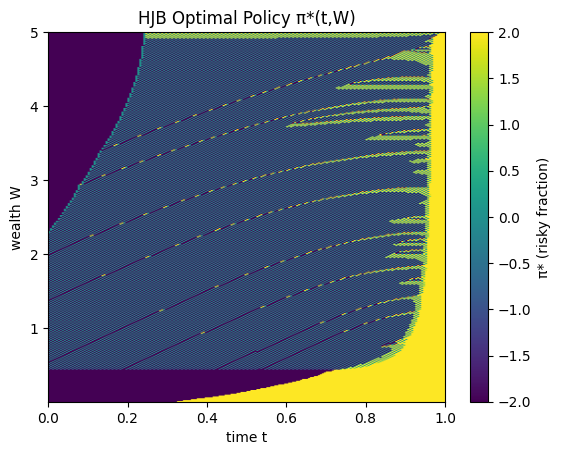

In [5]:
hjb_sol = solve_hjb_engine(inputs)

t_grid  = hjb_sol["t_grid"]
W_grid  = hjb_sol["W_grid"]
pi_star = hjb_sol["pi_star"]

plot_policy_heatmap(t_grid, W_grid, pi_star)

# 3. Output 2 : Strategy Simulation & Diagnostics

*This section shows how each strategy actually behaves when implemented on the same simulated market scenarios.*
*The wealth trajectories illustrate the dynamic risk and dispersion over time, while the terminal wealth distributions summarize the full outcome distribution at the investment horizon.*

*The average turnover diagnostic shows that HJB is the only truly state-dependent policy, leading to frequent allocation adjustments.
All other strategies use (quasi-)constant allocations in this framework, resulting in negligible turnover and much lower sensitivity to transaction costs.*

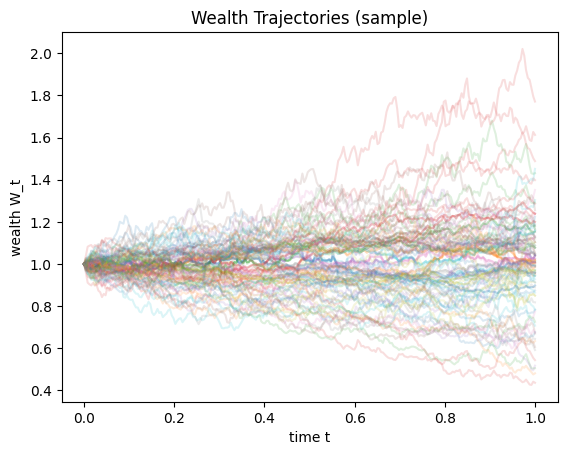

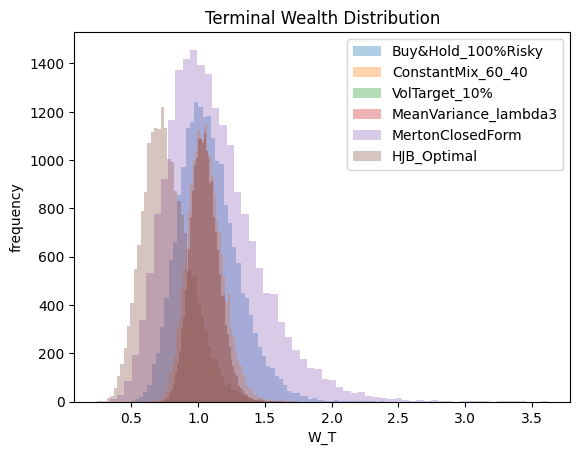

Buy&Hold_100%Risky        | avg turnover ≈ 0.000
ConstantMix_60_40         | avg turnover ≈ 0.000
VolTarget_10%             | avg turnover ≈ 0.000
MeanVariance_lambda3      | avg turnover ≈ 0.000
MertonClosedForm          | avg turnover ≈ 0.000
HJB_Optimal               | avg turnover ≈ 0.376


In [6]:
policies = build_policies(inputs, hjb_sol)
sim_res = simulate_strategies_engine(inputs, policies)

t = sim_res["t"]
wealth_paths = sim_res["wealth_paths"]

plot_wealth_trajectories(t, wealth_paths, n_paths=20)
plot_terminal_histograms(wealth_paths, bins=60)

for name, pi_path in sim_res["pi_paths"].items():
    avg_turnover = np.mean(np.abs(np.diff(pi_path, axis=1)))
    print(f"{name:25s} | avg turnover ≈ {avg_turnover:.3f}")

# 4. Output 3 : Strategy Comparison & Decision

*This table summarizes the final performance, risk, and utility metrics for all strategies under identical market scenarios.
While traditional metrics (mean wealth, Sharpe ratio, drawdown) provide useful intuition, the expected utility column is the decision criterion, as it fully reflects the investor’s risk aversion.*

*The strategy with the highest expected utility represents the optimal choice for this investor, highlighting the gap between theoretical optimality (HJB) and practical, implementable performance.*

In [7]:
metrics = evaluate_results_engine(inputs, sim_res)

df = pd.DataFrame(metrics).T
df

,terminal_mean,terminal_median,terminal_q05,terminal_q95,max_drawdown_mean,sharpe_annualized,expected_utility
Buy&Hold_100%Risky,1.081162,1.058966,0.761703,1.475638,-0.188461,0.288930,0.057810
ConstantMix_60_40,1.056287,1.048307,0.860262,1.279226,-0.114769,0.395558,0.047487
VolTarget_10%,1.050173,1.044614,0.885947,1.233118,-0.095481,0.438875,0.043906
MeanVariance_lambda3,1.050173,1.044614,0.885947,1.233118,-0.095481,0.438875,0.043906
MertonClosedForm,1.113263,1.062832,0.648366,1.748282,-0.273050,0.205624,0.061713
HJB_Optimal,0.768148,0.747967,0.500405,1.095111,-0.361725,-1.179707,-0.292032
